Fútbol Match Highlights<br>
Target Face Embedding - Capstone 2<br>
Tom Widdows

This notebook trains and saves a model that can distinguish between a target player's face and any other face.<br><br>

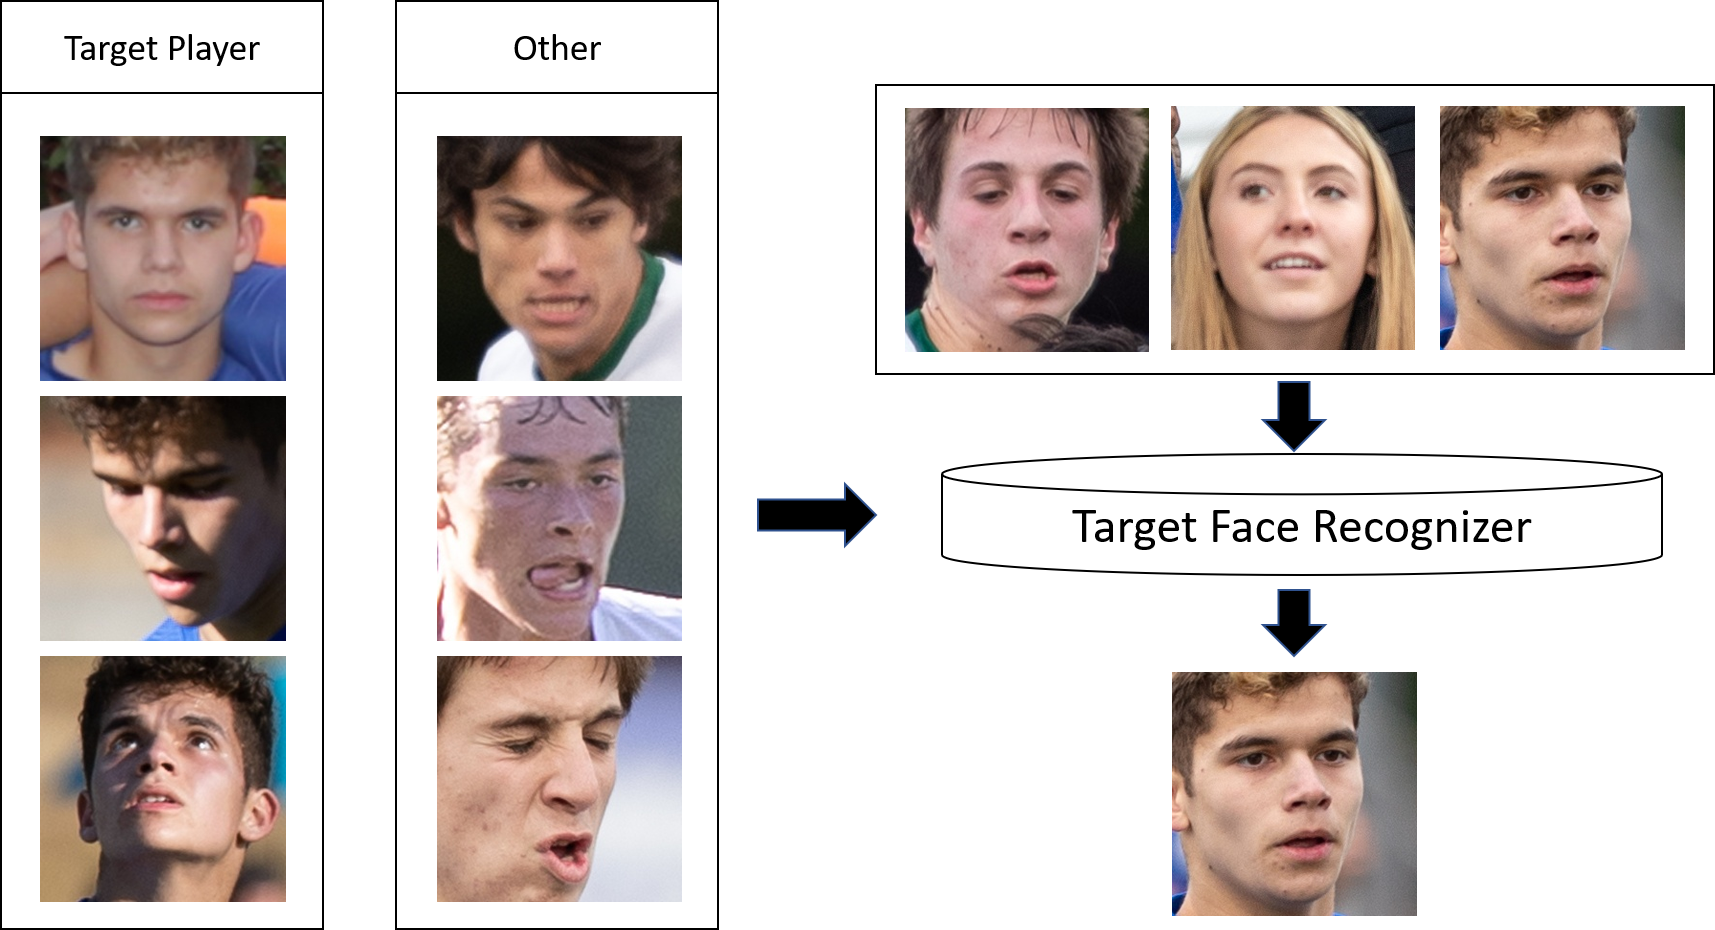

The main application loads this model and uses it for facial recognition. The notebooks purpose is to train and save a model for later use in the main applicaiton.

##### Housekeeping...

In [1]:
import sys
sys.path.append('../code')
import settings as s

import ast
from collections import Counter
import csv
import cv2
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp
from hyperopt.pyll.stochastic import sample
import lightgbm  as  lgb
from lightgbm import LGBMClassifier
from mtcnn import MTCNN
import numpy as np 
import pandas as pd 
from pathlib import Path
import pickle
import random
import shutil
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from support_class import Fball, time_it, FaceAligner
from measures import mcc_eval, mcc, eval_mcc, lgb_f1_score, lgb_kappa_score
import time
from timeit import default_timer as timer

start_all = time.time()  # track time for notebook to run
%matplotlib inline

Using TensorFlow backend.


##### Common variables and settings...

In [2]:
# common variables used throughout the notebook
random.seed(14)

recreate_all_profiles = True  # if False, existing face profiles will skipped as opposed to deleted and recreated

# save figure unique filenames
cm_valid_fig = Fball.checkfile('08 - 03 Extended Target Face Embedding Model CM Valid.jpg', ir=False)
cm_test_fig = Fball.checkfile('08 - 03 Extended Target Face Emberdding Model CM Test.jpg', ir=False)

#Hyperopt variables
hyperopt_trials = s.MODELS / 'target_face_recognizer_model_hyperopt_trials.csv'
N_FOLDS = 3
MAX_EVALS = 50

# classifiers
classification_algos_name = [
    "KNeighborsClassifier",
    "GaussianNB",
    "DecisionTreeClassifier",
    "ExtraTreeClassifier",
    "LGBMClassifier"
]

classification_algos = [
    KNeighborsClassifier(20),
    GaussianNB(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    LGBMClassifier()
]

##### Retrieve (or calculate) information on target player and other faces

In [3]:
# Populate df_target (known faces)
embedder = cv2.dnn.readNetFromTorch(str(s.MODELS / 'openface_nn4.small2.v1.t7'))
detector = MTCNN()  # we are finding this on the scaled image and storing points based on the scaled image
fa = FaceAligner(desired_face_width=256)

# Populate df_target (known faces)
# @time_it
def find_target_faces():
    
    def get_name(df):
        return df['face_file'].parts[-2]
   
    known_faces = list(Path(s.TARGET_FACES / 'extended').rglob('*.jpg'))
    unknown_faces = list(Path(s.UNKNOWN_FACES / 'extended').rglob('*.jpg'))
    
    df_known_faces = pd.DataFrame(known_faces, columns=['face_file'])
    df_known_faces['name'] = ''
    df_known_faces['name'] = df_known_faces.apply(get_name, axis=1)
    df_unknown_faces = pd.DataFrame(unknown_faces, columns=['face_file'])
    df_unknown_faces['name'] = '00_Unknown'
    df = df_known_faces.append(df_unknown_faces)
    
    if recreate_all_profiles:
        files = df['face_file'].to_numpy()
        names = df['name'].to_numpy()
    else:
        files=[]
        names=[]
        names_t = df['name'].to_numpy()
        for i, file in enumerate(df['face_file']):
            if not file.with_suffix('.pkl').is_file():
                files.append(file)
                names.append(names_t[i])


    for c, file in enumerate(files):
        print(str(c+1) + ' of ' + str(len(files)) + '  '+ str(names[c]) + '  ' +file.name + '                    ', end='\r')
        image = cv2.imread(str(file))
        result = detector.detect_faces(image)
        if len(result) != 1:
            f = file.parent / 'issues' 
            f.mkdir(parents=True, exist_ok=True)
            shutil.move(str(file), str(f))
            continue
        
        for i, face in enumerate(result):
            box=result[0]['box']
            (x, y, w, h) = max(box[0],0), max(box[1],0), box[0]+box[2], box[1]+box[3]
            rect = [x,y,w,h]
            faceAligned = fa.align(image, rect, face['keypoints']['left_eye'], face['keypoints']['right_eye'])
            vec = Fball.get_face_embedding(faceAligned,  embedder)
            dict = {'file_type':'target',
                    'name':names[c],
                    'target_file':file, 
                    'left_eye':face['keypoints']['left_eye'], 
                    'right_eye':face['keypoints']['right_eye'],
                    'nose':face['keypoints']['nose'], 
                    'mouth_left':face['keypoints']['mouth_left'], 
                    'mouth_right':face['keypoints']['mouth_right'],
                    'vec':vec
                   }
            with open(file.with_suffix('.pkl'), 'wb') as handle:
                pickle.dump(dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    Fball.bl()
    return
find_target_faces()
print('\nDone')

1068 of 1068  00_Unknown  Peter_Shulman_0025.jpg                              

Done


##### Load datasets and prepare data

In [4]:
target_list = []
pickle_files = list(Path(s.TARGET_FACES / 'extended').rglob('*.pkl')) + list(Path(s.UNKNOWN_FACES / 'extended').rglob('*.pkl'))
for pickle_file in pickle_files:
    with open(pickle_file, 'rb') as f:
        target_list.append(pickle.load(f))
df = pd.DataFrame(target_list)

In [5]:
cols = ['vec_'+str(i+1).zfill(3) for i in range(128)]
df = pd.concat([df, pd.DataFrame(df['vec'].values.tolist(), columns=cols)], axis=1)

In [6]:
le = LabelEncoder()
labels = le.fit_transform(df["name"])
# labels = le.fit_transform(names)
print(f'Positive class: {sum(labels)}')
print(f'Negative class: {len(labels)-sum(labels)}')
le.classes_

Positive class: 112
Negative class: 956


array(['00_Unknown', '11_Elijah_Widdows'], dtype=object)

##### Scale and split the data

In [7]:
X = df[cols]
y = labels

X_train, y_train, X_valid, y_valid, X_test, y_test, X_train_and_valid, y_train_and_valid, train_set = Fball.train_valid_test(X, y, hyperopt_train_set=True)  # remove train_set if SMOTE


Total Data:                   1,068  100%  X

Test (holdout) data:            107   10%  X_test
Train and Validation data:      961   90%  X_train_and_valid

Train data:                     768   72%  X_train
Validation data:                193   18%  X_valid


Note: Created train_set for Hyperopt


##### Balance classes utilizing SMOTE oversampling

In [8]:
# counter=Counter(labels)
# print(counter)

In [9]:
# msg='Resample X_train and y_train to balance classes...'
# X_train_res, y_train_res, train_set = Fball.balance_classes(X_train, y_train, msg, hyperopt_train_set=True)

In [10]:
# msg=('Resample X_train_and_valid and y_train_and_valid to balance classes...\n'
#     'This dataset is used to train the final model and predict on test (holdout) dataset')
# X_train_and_valid_res, y_train_and_valid_res = Fball.balance_classes(X_train_and_valid, y_train_and_valid, msg)

##### Run classifiers, compare performance and choose best classifier

In [11]:
# run the classifiers

start = time.time()
accuracy_score_list = []
f1_score_list = []
precision_score_list = []
recall_score_list = []
roc_auc_score_list = []
models = []

print(f'{"classsifier":<30} {"accuracy":<6}  {"f1_score":<6}  {"precision":<7}    {"recall":<6}   {"roc_auc":<6}  {"time":<15}')

for idx, mod in enumerate(classification_algos):
    start = time.time()
    model = mod
    model.fit(X_train, y_train)  # _res for SMOTE
    y_valid_pred = model.predict(X_valid)
    end = time.time()
    recall_score_list.append(recall_score(y_valid, y_valid_pred))
    precision_score_list.append(precision_score(y_valid, y_valid_pred))
    f1_score_list.append(f1_score(y_valid, y_valid_pred))
    accuracy_score_list.append(accuracy_score(y_valid, y_valid_pred))
    roc_auc_score_list.append(roc_auc_score(y_valid, y_valid_pred))

    print(f"{classification_algos_name[idx]:<30} {accuracy_score_list[idx]:>8.2%}  {f1_score_list[idx]:>8.2%}  {precision_score_list[idx]:>9.2%}  {recall_score_list[idx]:>8.2%}  {roc_auc_score_list[idx]:>8.2%}  {end-start:.2f} sec")
print(f'\n{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start)))}')

classsifier                    accuracy  f1_score  precision    recall   roc_auc  time           
KNeighborsClassifier             90.16%     9.52%    100.00%     5.00%    52.50%  0.05 sec
GaussianNB                       77.72%    39.44%     27.45%    70.00%    74.31%  0.01 sec
DecisionTreeClassifier           90.67%    52.63%     55.56%    50.00%    72.69%  0.12 sec
ExtraTreeClassifier              92.75%    66.67%     63.64%    70.00%    82.69%  0.00 sec
LGBMClassifier                   93.78%    62.50%     83.33%    50.00%    74.42%  0.41 sec

00:00:00


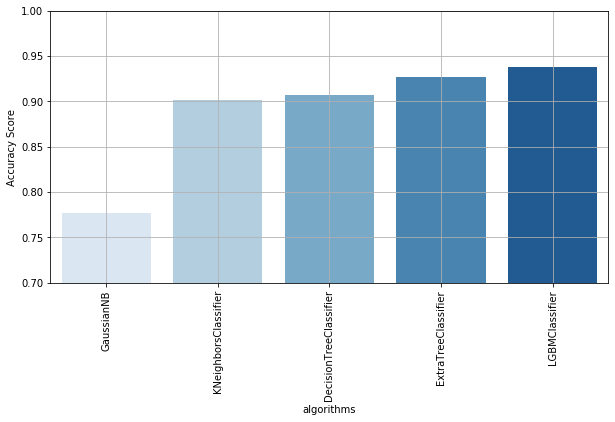

Best classifier: LGBMClassifier

Selecting LGBMClassifier
   LGBMClassifier has features_importances_
   LGBMClassifier does NOT has coef_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)



In [12]:
# compare the classifiers and look at best 
model_best_roc = Fball.plot_model_comparison(classification_algos_name, accuracy_score_list, [.7,1])
model = Fball.get_model_info(classification_algos, model_best_roc, classification_algos_name, X_train, y_train, show_feat_imp=False)  # _res for SMOTE

##### Train the best classifier on the train data and predict on the validation data

The baseline score (roc_auc) on the validation set is 90.98%



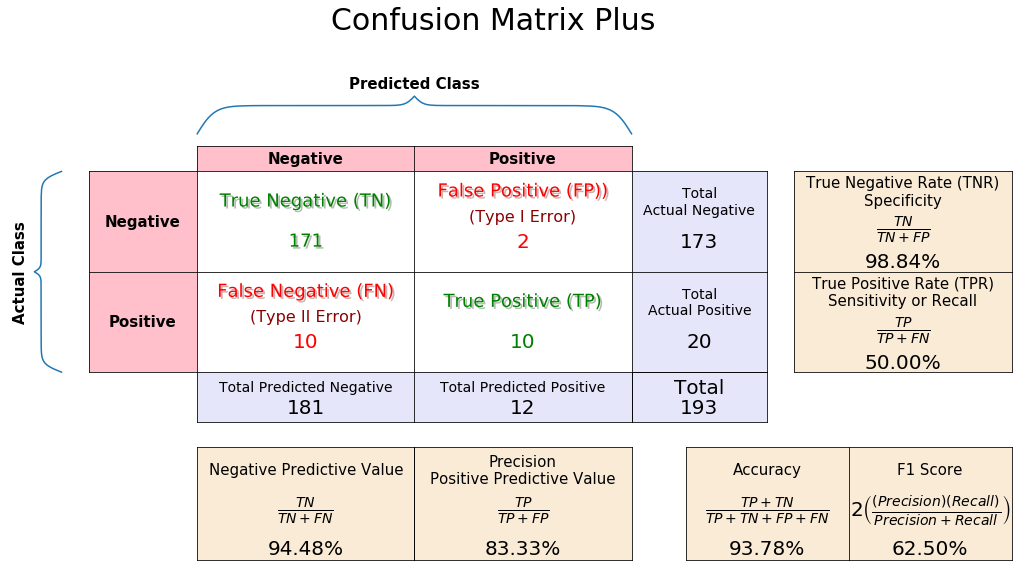


00:00:01


In [13]:
y_pred_prob = Fball.eval_model_valid(model, X_train, y_train, X_valid, y_valid)  # _res for SMOTE

##### Review the Confusion Matrix at cutoffs from 1 to 100

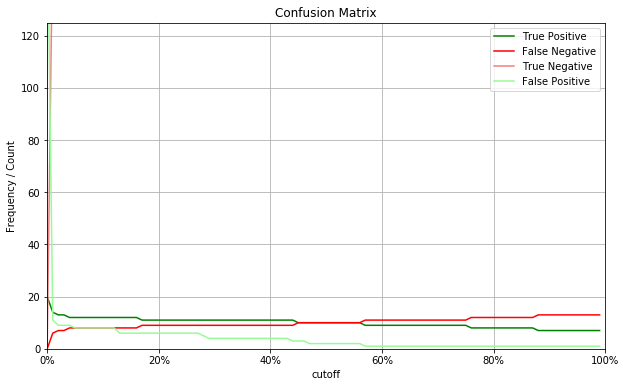

In [14]:
df_cutoff = Fball.graph_cutoff(y_pred_prob, y_valid)

##### Choose a cutoff based on the above plot and reevaluate using plots and confusion matrix below

In [15]:
_cutoff = 6

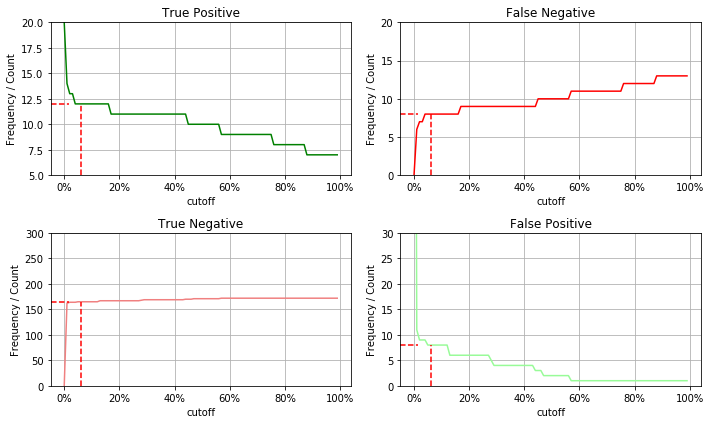

In [16]:
y_limits = [(5, 20), (0, 20), (0, 300), (0, 30)]
Fball.exploded_cm(df_cutoff, _cutoff, y_limits)

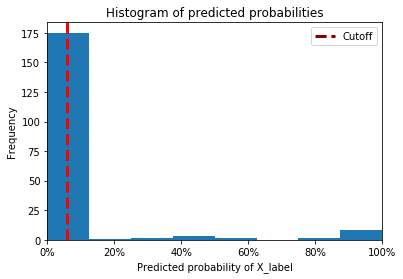

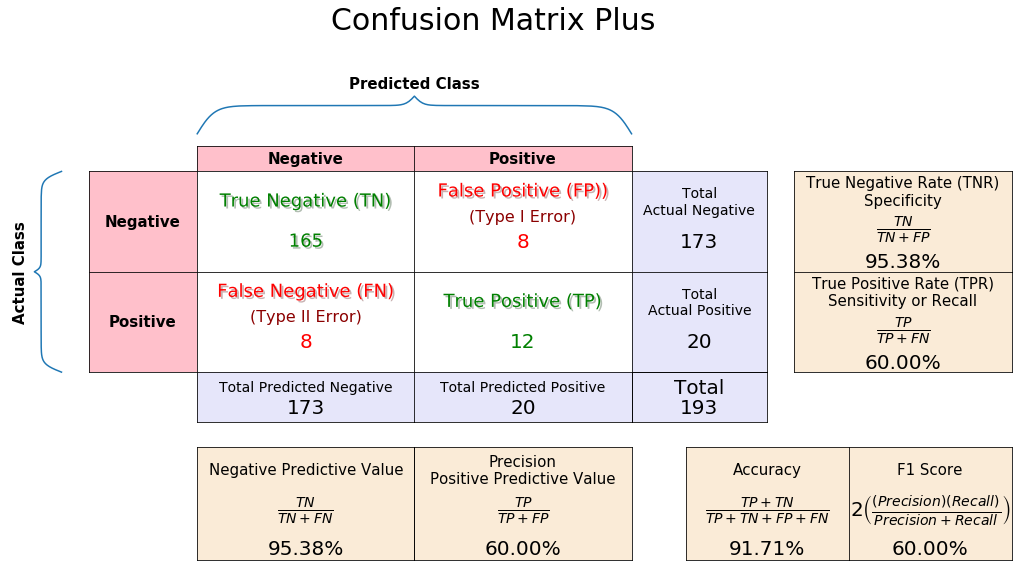

In [17]:
cutoff = Fball.cm_after_cutoff(_cutoff, y_pred_prob, X_valid, y_valid)

##### Tune Model

In [18]:
# N_FOLDS = 3  set in common variables

def objective(params, n_folds = N_FOLDS):
    """
    Objective function for Gradient Boosting Machine Hyperparameter Optimization
    Returns validation score from hyperparameters
    This is the function we are trying to minimize
    """
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'binary_logloss', feval=lgb_kappa_score)
#     print(cv_results)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['kappa-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['kappa-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [19]:
# Define the search space
space = {
    'num_leaves': hp.quniform('num_leaves', 25, 500, 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 10000, 200000, 10000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [20]:
# additional paramaters
bayes_trials = Trials()  # Keep track of results

out_file = hyperopt_trials  # File to save first results
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])  # Write the headers to the file
of_connection.close()

In [21]:
# run optimization

# MAX_EVALS set in common variables
global  ITERATION
ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50),
           show_progressbar=True)

100%|████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/trial, best loss: 0.3729648197706372]


In [22]:
# Sort the trials with lowest loss (highest MCC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:1] # show best trial

[{'loss': 0.3729648197706372,
  'params': {'colsample_bytree': 0.7183994614587972,
   'learning_rate': 0.12949966655294162,
   'min_child_samples': 25,
   'num_leaves': 255,
   'reg_alpha': 0.9882700594589847,
   'reg_lambda': 0.22086785952277388,
   'subsample_for_bin': 40000},
  'iteration': 21,
  'estimators': 46,
  'train_time': 1.6606735000000015,
  'status': 'ok'}]

In [23]:
results = pd.read_csv(hyperopt_trials)

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
# results.head()  # uncomment to view results

In [24]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train and validation data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(X_train, y_train)  # _res for SMOTE

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7183994614587972, importance_type='split',
               learning_rate=0.12949966655294162, max_depth=-1,
               min_child_samples=25, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=46, n_jobs=-1, num_leaves=255, objective='binary',
               random_state=50, reg_alpha=0.9882700594589847,
               reg_lambda=0.22086785952277388, silent=True, subsample=1.0,
               subsample_for_bin=40000, subsample_freq=0)

#### Predict on validation  data using Bayes optimized paramaters


The best model from Bayes optimization scores 93.93% AUC ROC on the validation set.
This was achieved after 21 search iterations



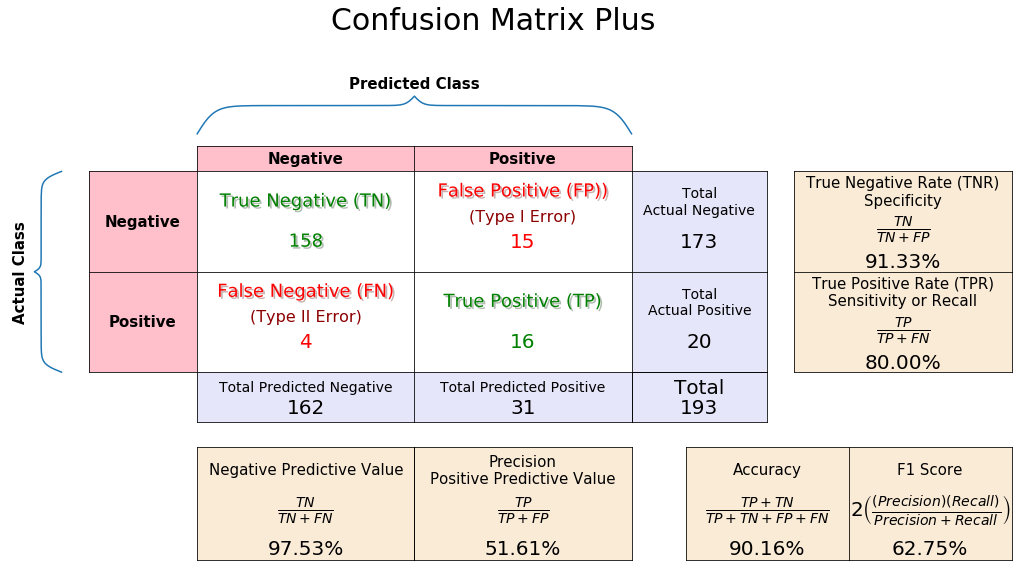


The kappa score is 57.38%

The MCC score is 59.21%



In [25]:
Fball.eval_hyperopt_on_valid(best_bayes_model, X_valid, y_valid, results, cutoff, print_kappa=True, print_mcc=True, save_fig=cm_valid_fig)

##### Predict on testing data using Bayes optimized paramaters

In [26]:
# retrain model with best paramaters using train and validation data
best_bayes_model.fit(X_train_and_valid, y_train_and_valid)  # _res for SMOTE

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7183994614587972, importance_type='split',
               learning_rate=0.12949966655294162, max_depth=-1,
               min_child_samples=25, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=46, n_jobs=-1, num_leaves=255, objective='binary',
               random_state=50, reg_alpha=0.9882700594589847,
               reg_lambda=0.22086785952277388, silent=True, subsample=1.0,
               subsample_for_bin=40000, subsample_freq=0)


The best model from Bayes optimization scores 96.02% AUC ROC on the test set.
This was achieved after 21 search iterations



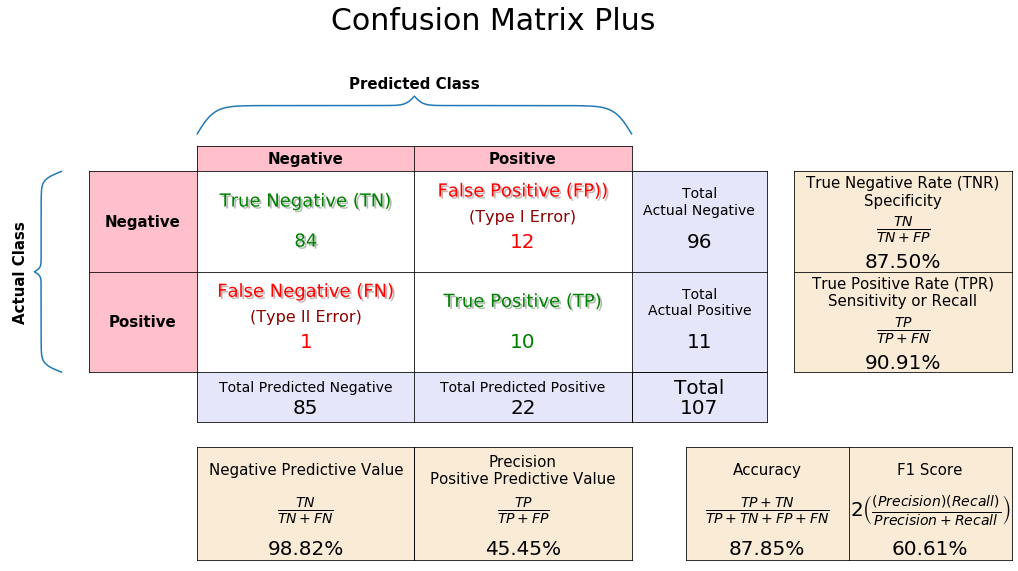


The kappa score is 54.35%

The MCC score is 58.92%



In [27]:
Fball.eval_hyperopt_on_test(best_bayes_model, X_test, y_test, results, cutoff, print_kappa=True, print_mcc=True, save_fig=cm_test_fig)

##### Save the model

In [28]:
# save the model to disk
Fball.save_model(best_bayes_model, 'extended_target_face_recognizer_model', ir=False)
Fball.save_model(le, 'extended_target_face_recognizer_label_encoding', ir=False)

In [29]:
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start_all)))}   ({MAX_EVALS:,.0f} Hyperopt evals)')

00:03:23   (50 Hyperopt evals)
